# Inference: Haario-Bardenet adaptive covariance MCMC

This example shows you how to perform Bayesian inference on a time series, using a variant of [Adaptive Covariance MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/haario_bardenet_ac_mcmc.html) detailed in supplementary materials of [1].

[1] Uncertainty and variability in models of the cardiac action potential:
    Can we build trustworthy models?
    Johnstone, Chang, Bardenet, de Boer, Gavaghan, Pathmanathan, Clayton,
    Mirams (2015) Journal of Molecular and Cellular Cardiology

It follows on from the [first sampling example](./first-example.ipynb).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.plot
import pints.toy

In [2]:
# Load a forward model
model = pints.toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Select random starting location for each chain: this method will sample from the `log_prior` distribution since a `pints.LogPosterior` has been supplied as the objective. (Note, this can be overridden by supplying a random sampling function as an input.) 

In [3]:
nchains = 4
xs = pints.sample_initial_points(log_posterior, nchains, parallel=True)

Create MCMC routine with four chains and run sampling.

Running...
Done!


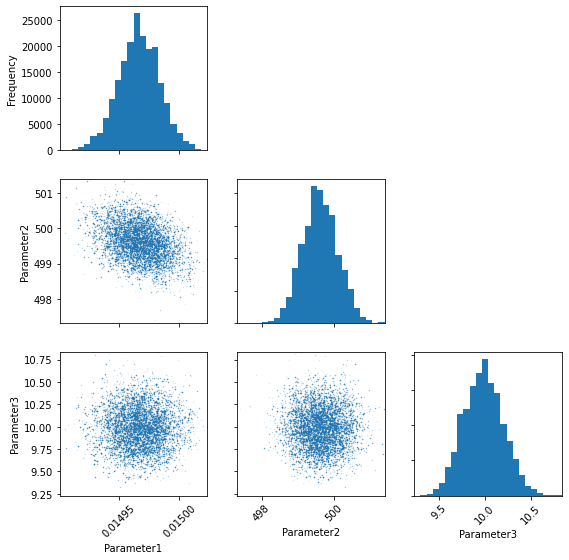

In [9]:
mcmc = pints.MCMCController(log_posterior, nchains, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Turn on parallel sampling
mcmc.set_parallel(True)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Discard warm up
chains = chains[:, 5000:, :]

# Look at distribution across all chains
pints.plot.pairwise(np.vstack(chains), kde=False)

# Show graphs
plt.show()

Use a results object to tabulate parameter-specific results.

In [10]:
results = pints.MCMCSummary(chains=chains, time=mcmc.time(), parameter_names=['r', 'k', 'sigma'])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess      ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  -------  --------------
r        0.01    0.00    0.01    0.01    0.01    0.01    0.01     1.00    1760.96  58.06
k        499.61  0.48    498.70  499.29  499.60  499.94  500.55   1.00    1602.51  52.84
sigma    9.98    0.21    9.58    9.83    9.98    10.13   10.41    1.00    1650.32  54.41
